In [242]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [243]:
# Cargamos el csv original
raw_file = '~/Desktop/Proyecto/raw/airbnb-listings.csv'
df = pd.read_csv(raw_file, delimiter=";", low_memory=False)

# Proyecto Final para el Bootcamp Mujeres en Tech - KeepCoding
- - -
En este proyecto exploraremos el [*dataset*](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets) propuesto y responderemos algunas preguntas que nos hemos planteado.

Trataremos con datos de Airbnb e intentaremos averiguar que datos tienen mayor impacto en el precio de las propiedades ofrecidas en alquiler.

Para eso tendremos que seguir algunos pasos:

## 1. Muestreo y exploración inicial de los datos:
### ¿Con que datos trabajaremos?

Hemos decidido trabajar con los datos de *Madrid*. Por lo que procederemos a quedarnos con esos datos específicos y posteriormente filtrar las columnas que creemos que serán útiles.

In [244]:
# Filtramos las filas y nos quedamos solo con las que contienen datos de Madrid
madrid_condition = df['State'].astype(str).str.contains('Madrid')
df = df[madrid_condition]

Elegimos las columnas listadas a continuación:

In [245]:
# Variable con las columnas que vamos a utilizar
columns_to_keep = ['ID', 'Host ID', 'Host Since', 'Neighbourhood', 'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Latitude', 'Longitude', \
                   'Amenities', 'Property Type', 'Room Type', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Cleaning Fee', 'Availability 365', \
                   'Review Scores Location', 'Cancellation Policy', 'Accommodates', 'Reviews per Month', 'Minimum Nights', 'Price', 'Monthly Price', 'Weekly Price']

# Nos quedamos solo con las columnas elegidas
df = df[columns_to_keep]
print(df.columns)

Index(['ID', 'Host ID', 'Host Since', 'Neighbourhood',
       'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Latitude',
       'Longitude', 'Amenities', 'Property Type', 'Room Type', 'Bathrooms',
       'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Cleaning Fee',
       'Availability 365', 'Review Scores Location', 'Cancellation Policy',
       'Accommodates', 'Reviews per Month', 'Minimum Nights', 'Price',
       'Monthly Price', 'Weekly Price'],
      dtype='object')


## 2. Normalización de las columnas

Algunas columnas tienen datos que no estan normalizados, como por ejemplo el código postal y el barrio.


In [246]:
# Normalizamos los valores de la columna Zipcode que contiene códigos postales erróneos y valores nulos
replace_values = {'nan': np.nan, '-': np.nan, '28': np.nan, '-' : np.nan, '2802\n28012' : '28012', '28002\n28002': '28002', '28051\n28051' : '28051', \
                  'Madrid 28004': '28004', '2815' : '28015', '2805' : '28005'}

df = df.replace({'Zipcode': replace_values})

En el caso del barrio, esta columna tenía muchos valores nulos. Nuestra decisión fue rellenar los nulos con los encontrados en la columna Neighbourhood Cleansed y luego descartar esta columna.

In [247]:
# Cambiamos los valores nulos de la columna Neighbourhood por el valor correspondiente de la columna Neighbourhood Cleansed
df['Neighbourhood'] = df['Neighbourhood'].fillna(df['Neighbourhood Cleansed'])

# Eliminamos la columna Neighbourhood Cleansed
df = df.drop('Neighbourhood Cleansed', axis = 1)

# Comprobamos que no quedan valores nulos
df['Neighbourhood'].isna().value_counts()

False    13198
Name: Neighbourhood, dtype: int64

### Columnas de texto
---

Vamos a analizar las columnas que son cadenas de texto y a quitar tildes, dobles espacios, ect



In [248]:
# Analizamos qué columnas necesitan normalización textual
for column in df.columns:
    if df[column].dtype == object:
        print(column)

# Variable con dichas columnas
str_columns = ['Neighbourhood', 'City', 'State', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

# Analizamos los caracteres no alfabéticos a conservar o a eliminar
for column in df.columns:
    if column in str_columns:
        temp_df = df[df[column].astype(str).str.contains('-|#|\.|,|;|:|_|&|/|Ç|\'|%|[|]|{|}|=|\?|¿|\(|\)|¡|!|\$|`\´|>|<|\||ª|º\\|@|\d|  ')]
        print(temp_df[column].unique())

# Función para eliminar los caracteres no alfa-numéricos y los dobles espacios
def no_alfa_num(text):
    characters = '-|_|\(|\)|  '
    for character in text:
        match = re.search(characters, text)
        if match:
            text = text.replace(match.group(0), ' ')
    return text

# Función para normalizar tildes y eñes
def normalize(text):
    characters = (('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ñ', 'n'))
    for a, b in characters:
        text = text.replace(a, b).replace(a.upper(), b.upper())
    return text

# Normalización de las columnas de texto
for column in df.columns:
    if column in str_columns:
        column_normalized = list(map(normalize, list(map(no_alfa_num, df[column].astype(str)))))
        df[column] = column_normalized

df[str_columns]

ID
Host Since
Neighbourhood
City
State
Zipcode
Amenities
Property Type
Room Type
Bed Type
Cancellation Policy
['Fuencarral-el Pardo' 'Fuencarral-El Pardo']
['Delicias-Madrid' 'Madrid, Comunidad de Madrid, ES' 'Centro, Madrid'
 'las matas  madrid' 'Madrid, Comunidad de Madrid, ESPANA'
 'Madrid, Vallecas (Fontarrón)' 'Aravaca (Madrid)' 'Chueca, Madrid']
['Madrid, Spain' 'España,Madrid']
['Bed & Breakfast' 'Camper/RV']
['Entire home/apt']
['Pull-out Sofa']
['super_strict_60' 'super_strict_30']


,Neighbourhood,City,State,Property Type,Room Type,Bed Type,Cancellation Policy
1021,Embajadores,Madrid,Comunidad de Madrid,Loft,Entire home/apt,Real Bed,moderate
1022,Embajadores,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,strict
1023,Embajadores,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,moderate
1024,Embajadores,Madrid,Community of Madrid,Apartment,Entire home/apt,Real Bed,strict
1025,Embajadores,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,strict
...,...,...,...,...,...,...,...
492516,Cortes,Centro,Madrid,Apartment,Private room,Futon,moderate
492517,Cortes,Madrid,Madrid,Apartment,Entire home/apt,Real Bed,flexible
492518,Cortes,Madrid,Comunidad de Madrid,Apartment,Private room,Real Bed,strict
492519,Cortes,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,moderate


### Conversión de tipos de datos
---

Algunos datos estaban en tipos incorrectos para su manejo, también hicimos las correcciones pertinentes.

- Host_Since a tipo fecha:

In [249]:
# Conversión de las fechas de 'Host Since' en date
df['Host Since'] = pd.to_datetime(df['Host Since'])

- ID de la propiedad a numérico en vez de string.

In [250]:
# Conversión del ID de la entrada en numérico en vez de string
df['ID'] = df['ID'].astype(int)

- El dataset scrapeado tenia una columna en pies cudrados. Decidimos convertirla en metros cuadrados para tener una mejor comprensión de la métrica.

In [251]:
df['Square Meters'] = df['Square Feet'] / 10.764
df['Square Meters']

1021     NaN
1022     NaN
1023     NaN
1024     NaN
1025     NaN
          ..
492516   NaN
492517   NaN
492518   NaN
492519   NaN
492520   NaN
Name: Square Meters, Length: 13198, dtype: float64

### Property Type
---

En el caso de esta variable, notamos que habia demasiadas clasificaciones con muy pocos registros, así que decidimos quedarnos con lo más relevante y agrupar el resto como "Otros".

Al ejecutar la siguiente celda se puede ver un gráfico en donde es obvio que la mayoría de las propiedades ofrecidas son *APARTAMENTOS*.

<AxesSubplot: >

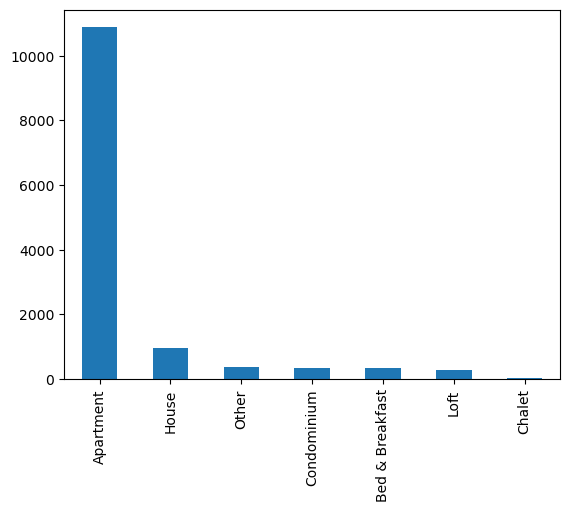

In [252]:
# Variable con los valores de Property Type que nos interesan (más comunes)
valid_property_types = ['House', 'Apartment', 'Bed & Breakfast', 'Condominium', 'Loft', 'Chalet', 'Hostal']
# Agrupamos los valores de Property Type y creamos un valor Other para el resto
property_types = df['Property Type']
property_types = property_types.map(lambda value: value if value in valid_property_types else 'Other')
df['Property Type'] = property_types
# Visualizamos el resultado
df['Property Type'].value_counts().plot.bar()

### Amenities
---

Aquí realmente basamos nuestras principales dudas sobre el dataset

Estabamos interesadas en conocer si habia alguna amenidad que influyese en el precio o si el numero total de amenidades tenia algun impacto

Primero decidimos revisar cuales eran mas amenidades más frecuentes, cuál era el precio medio y la diferencia de media de precios por amenidad

1. Como primer punto creamos un dataframe llamado "Amenities" que contiene cada amenidad como columna.

In [253]:
df_amenities = df.Amenities.fillna('').str.get_dummies(sep=',').astype(bool)
df_amenities

,24-hour check-in,Air conditioning,Baby bath,Babysitter recommendations,Bathtub,Breakfast,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),...,Suitable for events,TV,Table corner guards,Washer,Washer / Dryer,Wheelchair accessible,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
1021,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,True,True,True
1022,True,True,False,False,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False
1023,False,True,False,False,False,False,True,False,True,False,...,False,True,False,True,False,False,False,True,False,False
1024,False,True,False,False,False,False,False,True,False,False,...,False,True,False,True,False,False,False,True,False,False
1025,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492516,False,True,False,False,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,True,True
492517,True,True,False,False,False,False,True,False,True,False,...,False,True,False,True,False,True,False,True,False,False
492518,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
492519,True,True,False,False,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False


2. Luego calculamos la frecuencia de cada una de las amenities y generamos un gráfico de barras.

<AxesSubplot: title={'center': 'Frecuencia de las amenidades más comunes'}>

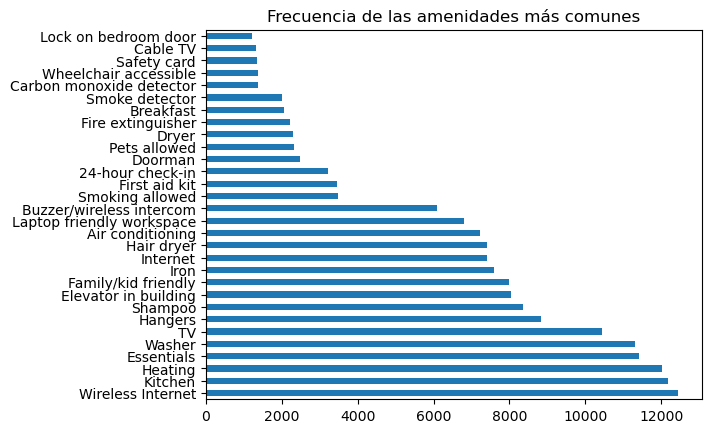

In [254]:
#Calculo de la frecuencia de las Amenities
df_amenities_frequency = pd.DataFrame()
for column in df_amenities.columns:
    df_amenities_frequency[column] = df_amenities[column].value_counts()

#Detectamos que tenemos dos variables con traslation missing. Las quitaremos dado que no aportan un valor real a nuestro análisis
df_amenities_frequency = df_amenities_frequency.drop('translation missing: en.hosting_amenity_49', axis = 1)
df_amenities_frequency = df_amenities_frequency.drop('translation missing: en.hosting_amenity_50', axis = 1)


#Plot de las frecuencias de las Amenities
plt.title("Frecuencia de las amenidades más comunes")
df_amenities_frequency.transpose()[True].sort_values(ascending=False).head(30).plot.barh()

Con esto podemos concluir que la mayoría de las propiedades cuentan con internet inalámbrico, cocina, calefacción, lavadora, ect.

<AxesSubplot: title={'center': 'Frecuencia de las amenidades menos comunes'}>

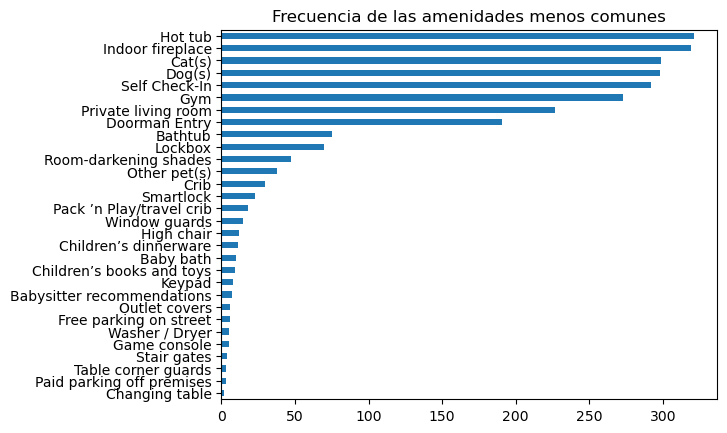

In [255]:
plt.title("Frecuencia de las amenidades menos comunes")
df_amenities_frequency.transpose()[True].sort_values(ascending=True).head(30).plot.barh()

Por el contrario es mas raro encontrar Mesa cambiadora, Parking fuera de la localidad, protectores para las esquinas de las mesas, protectores para escaleras...

Hay una clara tendencia a no tener propiedades acondicionadas para bebés/niños pequeños.

3. Ahora verificamos la media de precio por tener una amenidad en específico:

<AxesSubplot: title={'center': 'Media de Precios más altos por amenidad'}>

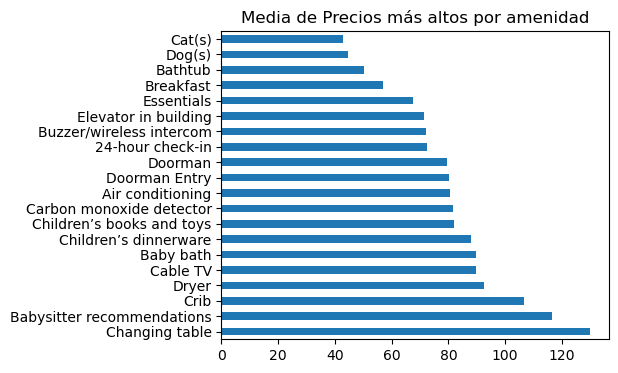

In [256]:
#Añadimos la columna 'Price' a nuestro dataframe.
df_amenities_price = df_amenities.join(df['Price'])
#Inicialicamos un dataframe para la media del precio.
df_amenities_price_mean = pd.DataFrame()
#Añadimos columnas que nos den la media por amenity
for column in df_amenities.columns:
    df_amenities_price_mean[column] = df_amenities_price.groupby(column)['Price'].mean()
#Hacemos la traspuesta para poder agrupar en el eje correcto cada una de las amenities.
df_amenities_price_mean = df_amenities_price_mean.transpose()
plt.title("Media de Precios más altos por amenidad")

df_amenities_price_mean[True].head(20).sort_values(ascending=False).plot.barh(figsize=(5, 4))

Tras ver esto, lo que suele tener más impacto en la media del precio suelen ser cosas asociadas a habitaciones preparadas para infantes como la mesita cambiadora y las recomendaciones de niñeras.

4. Nos parecio bien verificar *cuales amenidades generaban una mayor variación en el precio medio*

In [257]:
#Añadimos a nuestro DataFrame una columna 'Diff' que registra la diferencia de media de precio entre tener el amenity o no.
df_amenities_price_mean['Diff'] = df_amenities_price_mean[True] - df_amenities_price_mean[False]
df_amenities_price_mean.sort_values(by='Diff', ascending=False).head(20)

24-hour check-in,False,True,Diff
Paid parking off premises,65.710754,165.000000,99.289246
High chair,65.672611,132.416667,66.744055
Changing table,65.723591,130.000000,64.276409
Washer / Dryer,65.711089,124.400000,58.688911
Babysitter recommendations,65.706342,116.571429,50.865087
Indoor fireplace,64.679176,108.263323,43.584147
Crib,65.640094,106.633333,40.993239
Pack ’n Play/travel crib,65.678840,105.611111,39.932271
Air conditioning,47.771644,80.541984,32.770339
Dryer,60.152421,92.365427,32.213006


<AxesSubplot: >

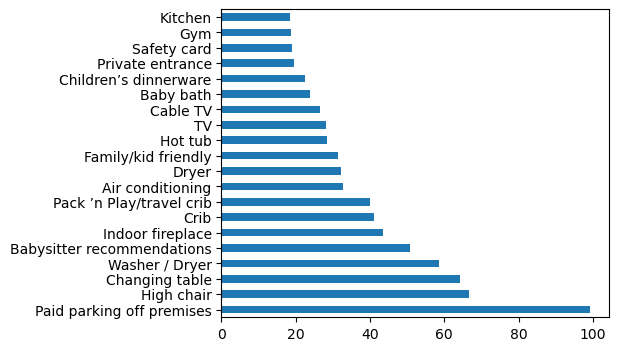

In [258]:
df_amenities_price_mean['Diff'].sort_values(ascending=False).head(20).plot.barh(figsize=(5, 4))

Tenemos ya que lo mas diferencia hace parece ser el Parking pagado fuera del terreno de la propiedad, la silla alta (para bebés), la mesa cambiadora, lavadora/secadora...

Al hacer esto, tenemos algunas amenities que tienen algun impacto significativo, sin embargo quedaría pendiente analizar estas variables más a fondo para tener conclusiones más fiables.

Puede ser que simplemente sean amenidades muy raras y casualmente estén en inmuebles con un mayor precio.


5. Otro aspecto que decidimos explorar es la relación de la cantidad de amenidades con el precio.


In [259]:
#Preparamos nuestro dataframe Amenities_Count
df_amenities_count = pd.DataFrame()
#Le añadimos la columna con el conteo de amniddes y el precio.
df_amenities_count['Amenities Count'] = df['Amenities'].str.split(',').fillna('').map(lambda x: len(x))
df_amenities_count = df_amenities_count.join(df['Price'])
df_amenities_count

,Amenities Count,Price
1021,15,50.0
1022,16,50.0
1023,18,77.0
1024,10,50.0
1025,10,95.0
...,...,...
492516,19,55.0
492517,22,80.0
492518,10,50.0
492519,17,70.0


<AxesSubplot: xlabel='Amenities Count'>

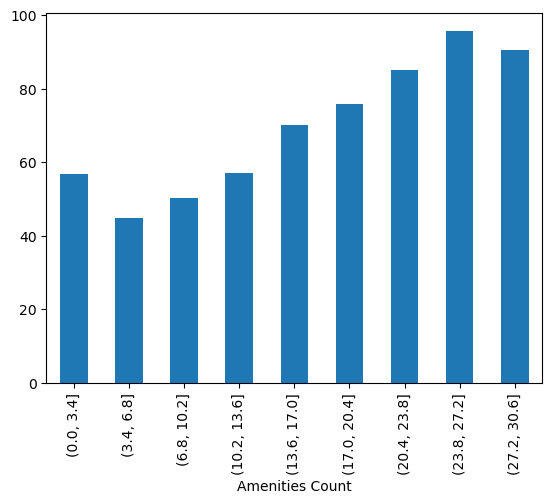

In [260]:
# Visualizamos la variación del precio medio de las propiedades en función de cuántas amenities totales tienen, agrupando el conteo en 10 grupos
steps = 10
max = df_amenities_count['Amenities Count'].max()
stept = max / steps
steps = np.arange(0, max, stept)
groups = pd.cut(df_amenities_count['Amenities Count'], steps)
df_amenities_count.groupby(groups)['Price'].mean().plot.bar()

Parece ser que el precio varia, alcanzando su minimo las propiedades que tienen 3-7 amenities y se dispara al ofrecer 24-27 amenidades.

La tendencia es subir de precio mientras más amenidades ofrezcas.

### Ratio de Ocupación.
---

La tasa de ocupación es un término que se utiliza para saber cuánto tiempo pasa un espacio rentado en relación a cuánto tiempo pasa disponible.

En este caso pongamos el ejemplo de una propìedad que se encuentra disponible 365 días al año pero solo fue rentada los fines de semana. Es decir, estuvo rentada 104 días de 365.

Eso nos daria una tasa de ocupación del 28,49%

Este dataset no nos da información sobre la tasa de ocupación pero se puede obtener relacionando datos como la media de reviews al mes, el minimo de noches y la disponibilidad anual

Pongamos el caso de una propiedad con un minimo de noches de 2, con 4 reviews al mes y una disponibilidad de 365 días al año.

Si dividimos las (reviews * minimo de noches) * 12 / 365. Esto nos daria el ratio de ocupación, asumiendo que cada individuo que va a la propiedad deja una review.

Decidimos explorar si esto nos daba algun tipo de dato valioso.

Como primer paso definimos una función para calcular esto:

In [261]:
def calculate_occupancy(reviews_month, min_nights, availability):
    return ((reviews_month * min_nights) * 12 / availability)

<AxesSubplot: xlabel='Occupancy'>

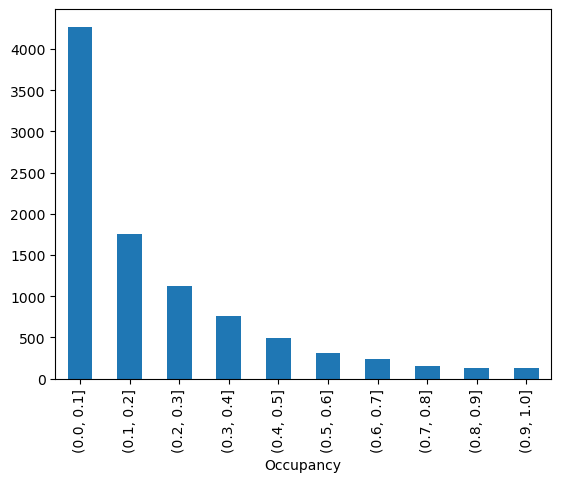

In [262]:
reviews = df['Reviews per Month'].fillna(0)
nights = df['Minimum Nights'].fillna(0)
availability = df['Availability 365'].fillna(0).map(lambda value: value if value != 0 else 9999999)

df['Occupancy'] = calculate_occupancy(reviews, nights, availability)

steps = np.arange(0, 1.01, 0.1)
groups = pd.cut(df['Occupancy'], steps)
df.groupby(groups).size().plot.bar()

Finalmente decidimos que este dato no era fiable y no continuamos indagando en utilidad.

### Bathrooms
---
Analizamos un poco la variable de los baños para tener un insight de si afectsa el precio final o no.


<AxesSubplot: xlabel='Bathrooms'>

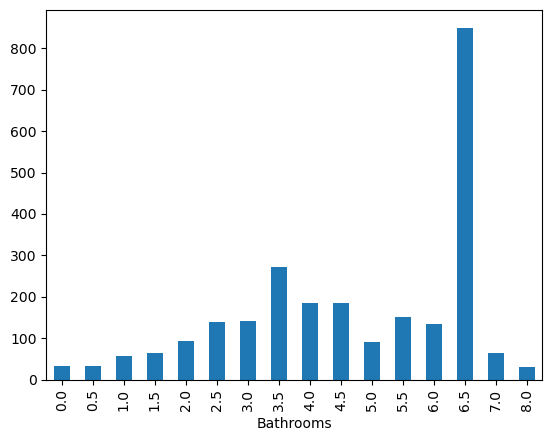

In [263]:
#Creamos un plot que nos muestra la media de precio por número de baños.
df.groupby('Bathrooms')['Price'].mean().plot.bar()

Vemos un poco la distribución de la media de precios, que sube hasta llegar a 3.5. En el caso de muchos baños es bastante probable que solo se encuentren en propiedades muy grandes con precios bastante elevados.

Decidimos ver la distribución de la cantidad de baños por propiedad

<AxesSubplot: >

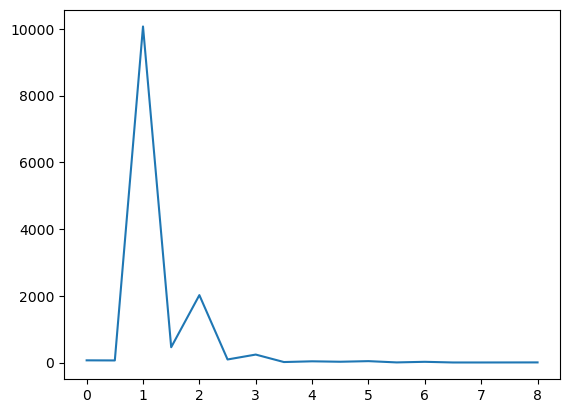

In [264]:
df['Bathrooms'].value_counts().sort_index().plot()

La mayoría de las propiedades tienen de 1 a 2 baños.

# Bedrooms
---

Hicimos un analisis similar al anterior

Primero por precio medio por numero de habitacines:

<AxesSubplot: xlabel='Bedrooms'>

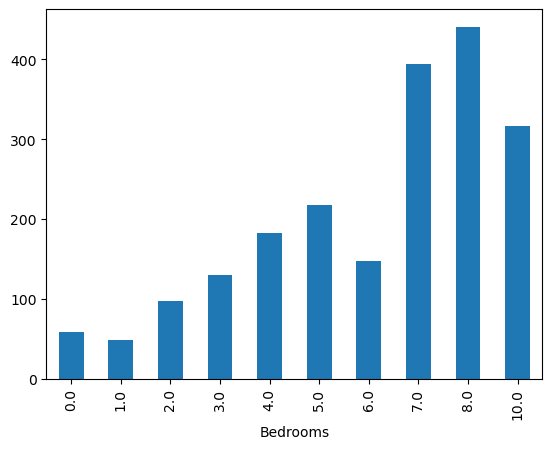

In [265]:
df.groupby('Bedrooms')['Price'].mean().plot.bar()

Lógicamene el precio sube por cantidad de habitaciones. En el número 6 puede que baje porque sea un hostal con varias habitaciones, lo que lo haría mas barato.

<AxesSubplot: >

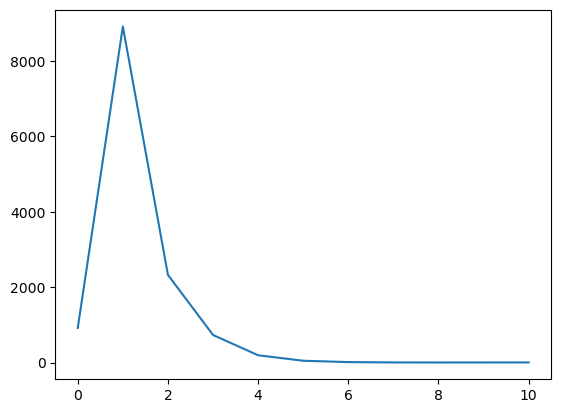

In [266]:
df['Bedrooms'].value_counts().sort_index().plot()

Sin embargo, la mayor parte de las propiedades tienen de 1 a 3 habitaciones.

### Beds
---

Hicimos algo similar tambien con el número de camas.

<AxesSubplot: xlabel='Beds'>

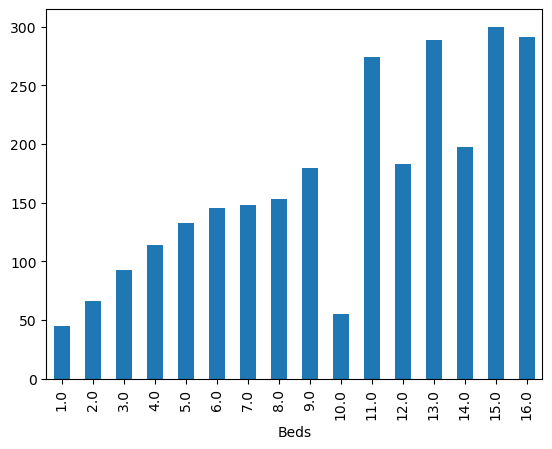

In [267]:
df.groupby('Beds')['Price'].mean().plot.bar()

Vemos una progresión en el precio a medida que aumentan las camas, a pesar de algunas excepciones que tendrían que estudiarse mas detalladamente

<AxesSubplot: >

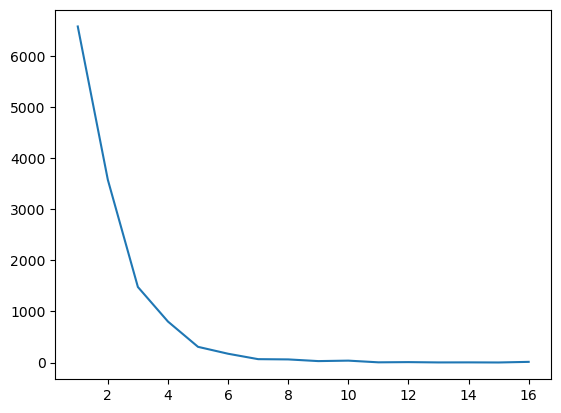

In [268]:
df['Beds'].value_counts().sort_index().plot()

Y que la mayor parte de los alojamientos tienen entre 1-6 camas.

En líneas generales los resultados de *Bathrooms, Bedrooms y Beds* son los esperados. A mayor cantidad de estos features tiende a subir el precio y la mayoría de los alojamientos tienen entre 1-3 baños, camas o habitaciones.

### Cleaning Fee
---

También miramos el Cleaning Fee:

<AxesSubplot: xlabel='Cleaning Fee'>

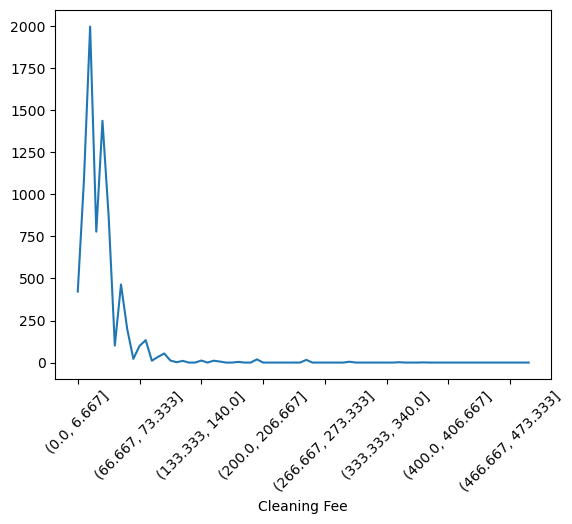

In [269]:
df['Cleaning Fee'] = df['Cleaning Fee'].fillna(0)

steps = 75
stept = df['Cleaning Fee'].max() / steps
steps = np.arange(0, df['Cleaning Fee'].max(), stept)
groups = pd.cut(df['Cleaning Fee'], steps)
df.groupby(groups).size().plot(rot=45)

La mayoría tiene un cleaning fee entre 0€ y 75€

### Neighbourhood

Decidimos averiguar cuales eran los barrios mas caros por precio por noche:

<AxesSubplot: xlabel='Neighbourhood'>

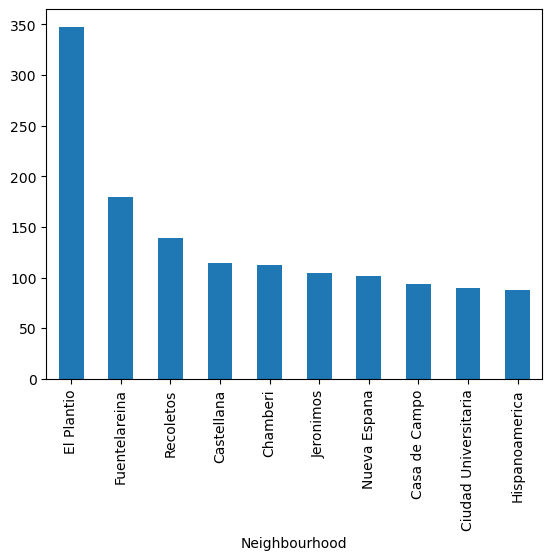

In [270]:
df.groupby('Neighbourhood')['Price'].mean().sort_values(ascending=False).head(10).plot.bar()

Tambien por precio semanal.

<AxesSubplot: xlabel='Neighbourhood'>

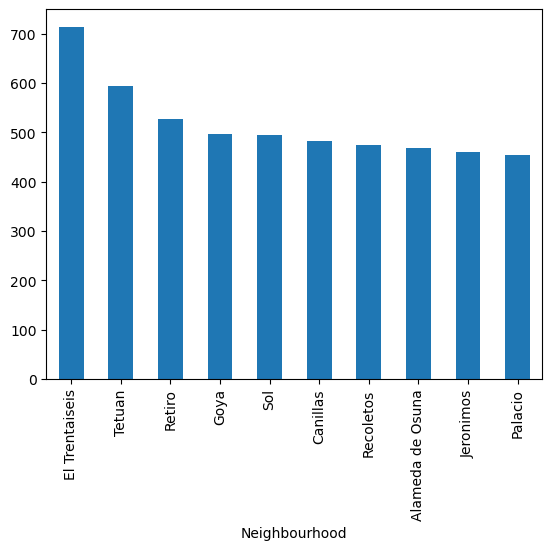

In [271]:
df.groupby('Neighbourhood')['Weekly Price'].mean().sort_values(ascending=False).head(10).plot.bar()

Y por precio mensual.

<AxesSubplot: xlabel='Neighbourhood'>

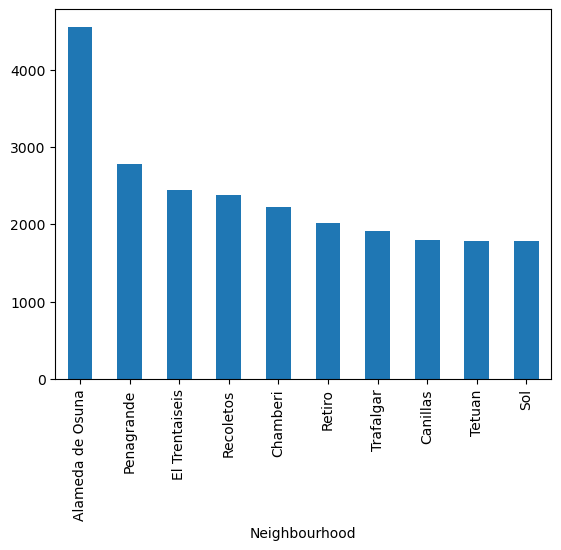

In [272]:
df.groupby('Neighbourhood')['Monthly Price'].mean().sort_values(ascending=False).head(10).plot.bar()

También nos preguntamos sobre los barrios con un ratio de ocupación más alto:

<AxesSubplot: xlabel='Neighbourhood'>

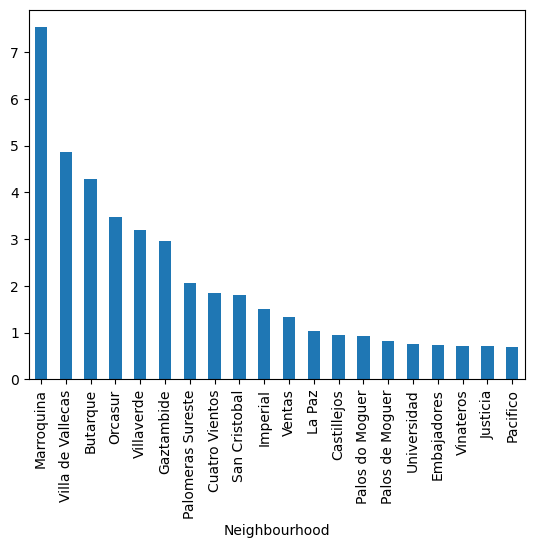

In [273]:
df.groupby('Neighbourhood')['Occupancy'].mean().sort_values(ascending=False).head(20).plot.bar()

En este caso el ratio de ocupación también puede estar relacionado con la cantidad de propiedades disponibles en ese barrio en especifico.

Con lo cual la tasa de ocupación por barrio sigue sin ser un indicador muy fiable.

Sin embargo nos preguntamos que barrio tenia mas alojamientos en alquiler:

<AxesSubplot: xlabel='Neighbourhood'>

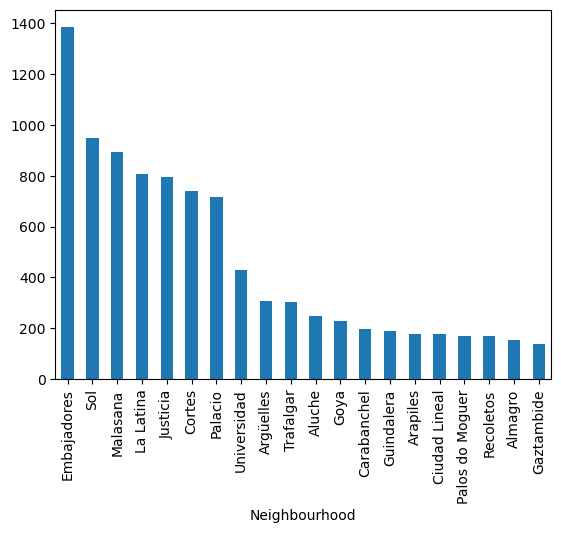

In [274]:
df.groupby('Neighbourhood').size().sort_values(ascending=False).head(20).plot.bar()

### Square Feet / Square Meters

Quisimos averiguar la media de metros cuadrados por propiedad

<AxesSubplot: xlabel='Square Meters'>

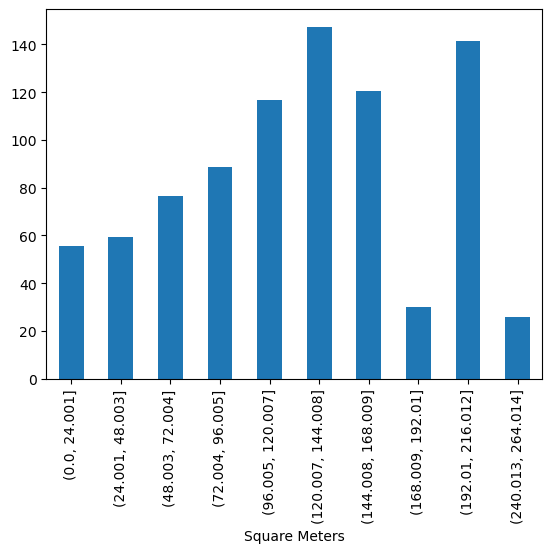

In [275]:
steps = 20
stept = df['Square Meters'].max() / steps
steps = np.arange(0, df['Square Meters'].max(), stept)
groups = pd.cut(df['Square Meters'], steps)
df.groupby(groups)['Price'].mean().dropna().plot.bar()

La mayoria podria estar entre 96 y 170 metros cuadrados.

También nos intereso saber cuales eran los varios que ofrecian pisos más grandes:

<AxesSubplot: xlabel='Neighbourhood'>

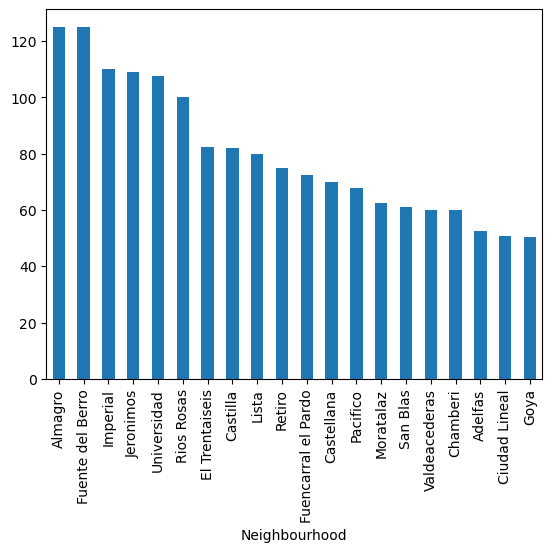

In [276]:
df.groupby('Neighbourhood')['Square Meters'].mean().sort_values(ascending=False).head(20).plot.bar()

O mas pequeños

<AxesSubplot: xlabel='Neighbourhood'>

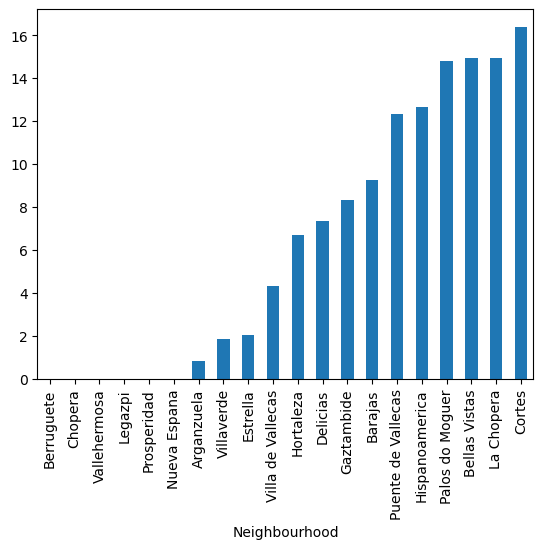

In [277]:
df.groupby('Neighbourhood')['Square Meters'].mean().dropna().sort_values(ascending=True).head(20).plot.bar()

### Property Type

Finalmente decidimos explorar los tipos de propiedades ofertados

Primero verificando el precio medio por tipo de propiedad

<AxesSubplot: xlabel='Property Type'>

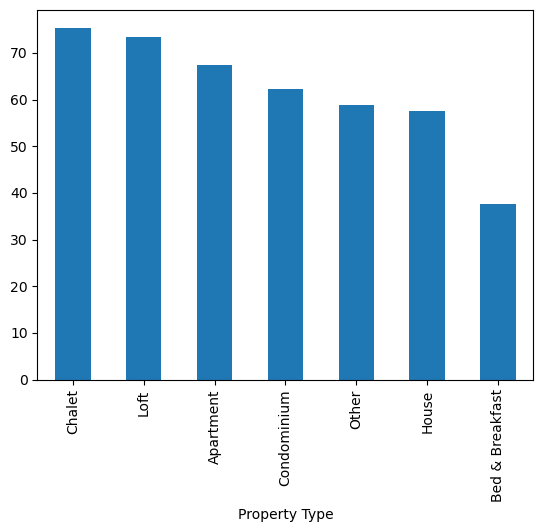

In [278]:
df.groupby(['Property Type'])['Price'].mean().sort_values(ascending=False).head(20).plot.bar()

Y verificando las variaciones de la mediana por tipo de propiedad

Para esto decidimos usar el boxplot por lo cual, para tener una mejor visualición, creamos la columna 'Log Price'


In [279]:
df['Log Price'] = real_price.apply(np.log)
df['Log Price']

1021      3.912023
1022      3.912023
1023      4.343805
1024      3.912023
1025      4.553877
            ...   
492516    4.007333
492517    4.382027
492518    3.912023
492519    4.248495
492520    4.488636
Name: Log Price, Length: 13198, dtype: float64

Hacemos el analisis según el tipo de propiedad:

<AxesSubplot: >

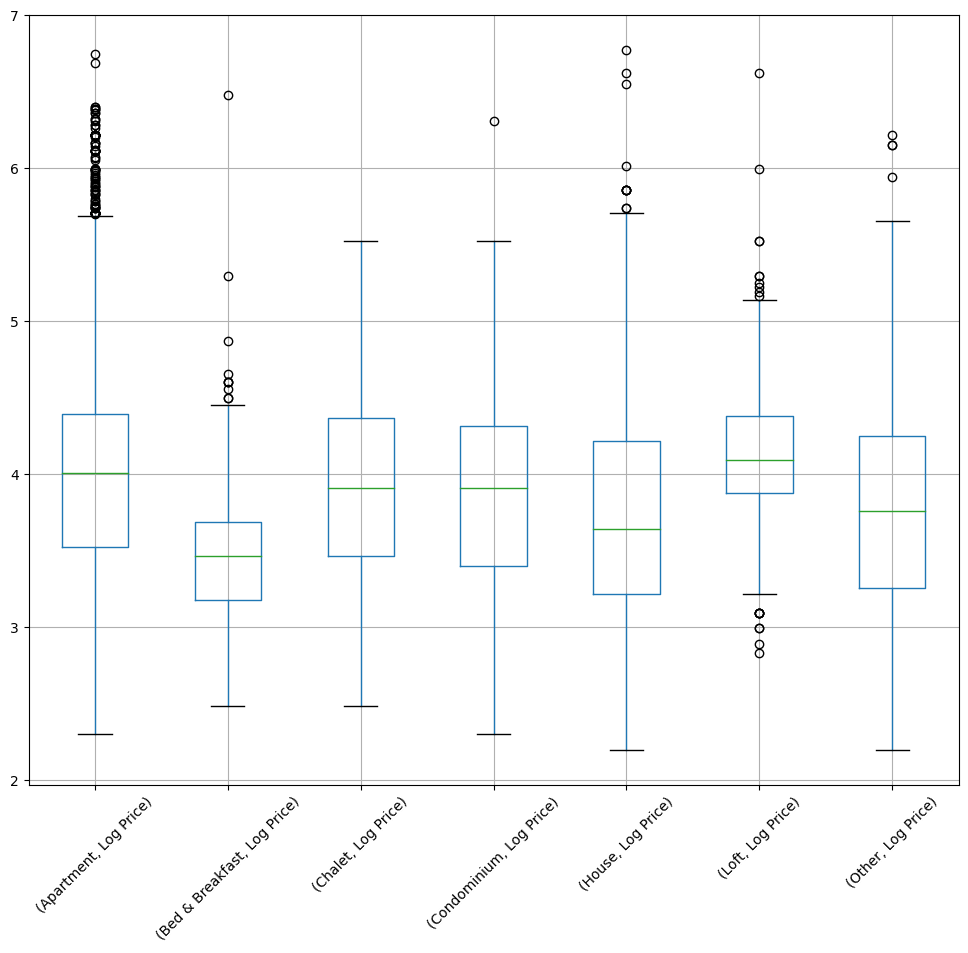

In [280]:
df.groupby('Property Type')[['Property Type', 'Log Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)

Esto lo que nos dice es que la mediana se mantiene mas o menos constante, entre los 35 y 40 €.

Lo hicimos según el tipo de habitación:

<function matplotlib.pyplot.show(close=None, block=None)>

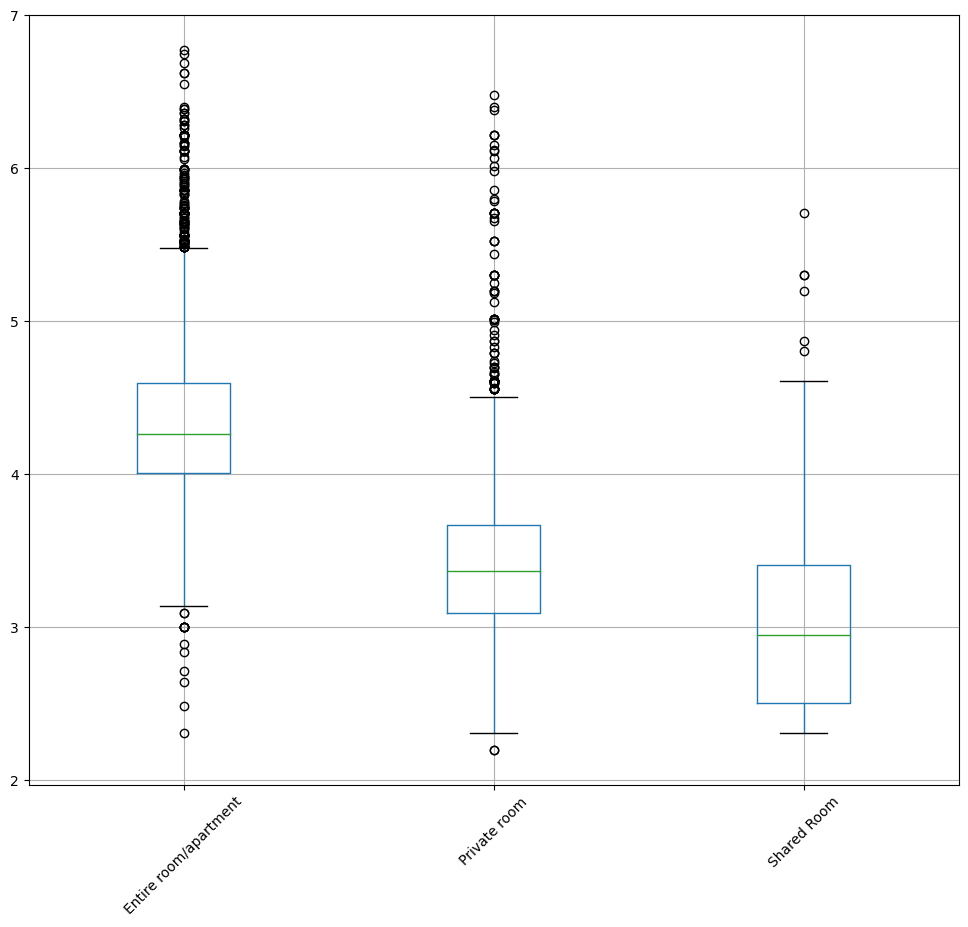

In [281]:
new_labels = ['Entire room/apartment', 'Private room', 'Shared Room'] # lista con las nuevas etiquetas
df.groupby('Room Type')[['Room Type', 'Log Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)
plt.xticks([1, 2, 3], new_labels)
plt.show

Como era de esperar, un departamento entero es mas costoso que un cuarto privado y un cuarto compartido

Ninguna sorpresa aquí.

Hicimos lo mismo por tipo de cama

<function matplotlib.pyplot.show(close=None, block=None)>

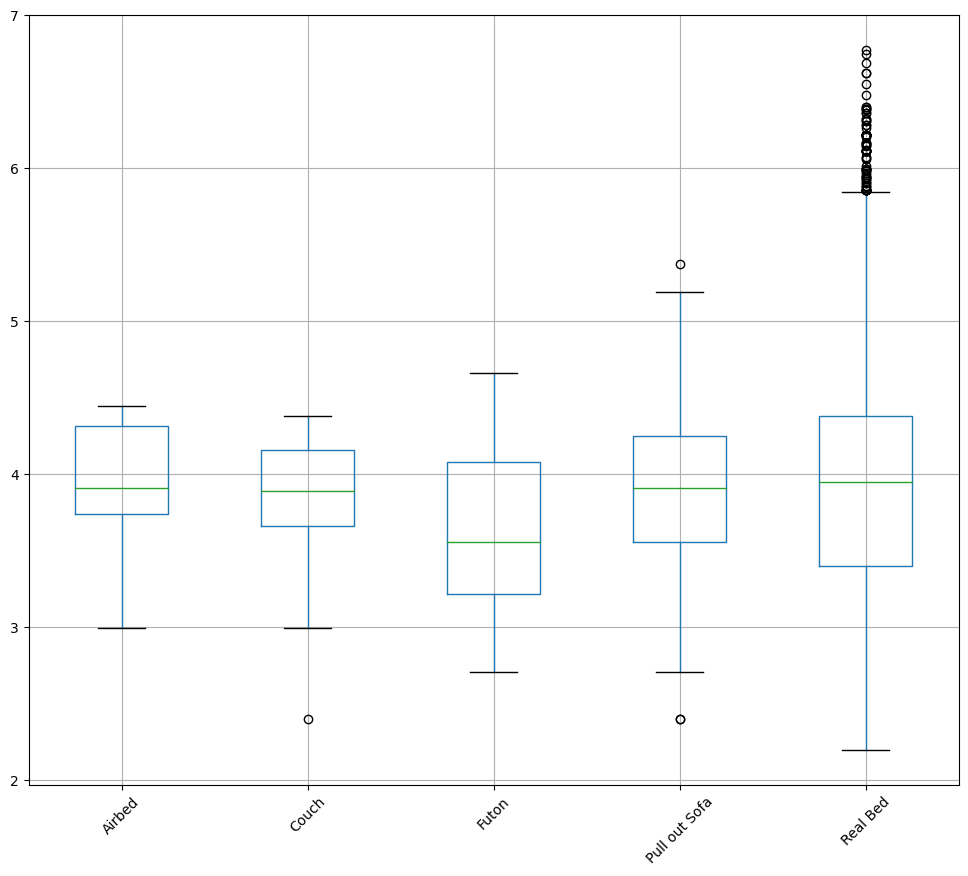

In [282]:
new_labels = ['Airbed', 'Couch', 'Futon', 'Pull out Sofa', 'Real Bed']
df.groupby('Bed Type')[['Log Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)
plt.xticks([1, 2, 3, 4, 5], new_labels)
plt.show

## Conclusión

La conclusión que pudimos sacar es que el precio es una variable sumamente compleja que se ve afectada por varios factores. El barrio, las amenidades, el tamaño del alojamiento, el número de habitaciones.

En ocasiones los datos se han comportado como esperabamos, en otros casos no ha sido así.

Por supuesto, se podría hacer un análisis más profundo sobre algunas variables y añadir algunos KPI's más para el desarrollo sin embargo consideramos esto un buen punto de partida para nuestro modelo predictivo.
